In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
# Impostazioni di visualizzazione
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [4]:
file_path = "/home/alessandro-merenda/Data/archive-2/Base.csv"

# Carica il dataset
df = pd.read_csv(file_path)

df

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,0,0.3,0.986506,-1,25,40,0.006735,102.453711,AA,1059,...,0,1500.0,0,INTERNET,16.224843,linux,1,1,0,0
1,0,0.8,0.617426,-1,89,20,0.010095,-0.849551,AD,1658,...,0,1500.0,0,INTERNET,3.363854,other,1,1,0,0
2,0,0.8,0.996707,9,14,40,0.012316,-1.490386,AB,1095,...,0,200.0,0,INTERNET,22.730559,windows,0,1,0,0
3,0,0.6,0.475100,11,14,30,0.006991,-1.863101,AB,3483,...,0,200.0,0,INTERNET,15.215816,linux,1,1,0,0
4,0,0.9,0.842307,-1,29,40,5.742626,47.152498,AA,2339,...,0,200.0,0,INTERNET,3.743048,other,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,0,0.8,0.124690,-1,143,30,0.051348,-0.826239,AB,530,...,0,1500.0,0,INTERNET,16.967770,other,0,1,0,7
999996,0,0.9,0.824544,-1,193,30,0.009591,0.008307,AC,408,...,1,1000.0,0,INTERNET,1.504109,macintosh,0,1,0,7
999997,0,0.8,0.140891,-1,202,10,0.059287,50.609995,AA,749,...,0,200.0,0,INTERNET,16.068595,other,0,1,0,7
999998,0,0.9,0.002480,52,3,30,0.023357,-1.313387,AB,707,...,0,200.0,0,INTERNET,1.378683,linux,1,1,0,7


In [5]:
# Informazioni sul dataset
df.info()
df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 32 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   fraud_bool                        1000000 non-null  int64  
 1   income                            1000000 non-null  float64
 2   name_email_similarity             1000000 non-null  float64
 3   prev_address_months_count         1000000 non-null  int64  
 4   current_address_months_count      1000000 non-null  int64  
 5   customer_age                      1000000 non-null  int64  
 6   days_since_request                1000000 non-null  float64
 7   intended_balcon_amount            1000000 non-null  float64
 8   payment_type                      1000000 non-null  object 
 9   zip_count_4w                      1000000 non-null  int64  
 10  velocity_6h                       1000000 non-null  float64
 11  velocity_24h                      1000

Index(['fraud_bool', 'income', 'name_email_similarity',
       'prev_address_months_count', 'current_address_months_count',
       'customer_age', 'days_since_request', 'intended_balcon_amount',
       'payment_type', 'zip_count_4w', 'velocity_6h', 'velocity_24h',
       'velocity_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'employment_status',
       'credit_risk_score', 'email_is_free', 'housing_status',
       'phone_home_valid', 'phone_mobile_valid', 'bank_months_count',
       'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'source',
       'session_length_in_minutes', 'device_os', 'keep_alive_session',
       'device_distinct_emails_8w', 'device_fraud_count', 'month'],
      dtype='object')

In [6]:
# Identificazione e gestione dei valori mancanti
potential_missing_values = [-1]
missing_custom = {}
for col in df.columns:
    count = df[col].isin(potential_missing_values).sum()
    if count > 0:
        missing_custom[col] = count / len(df) * 100
missing_custom_summary = pd.DataFrame({
    'Colonna': missing_custom.keys(),
    'Percentuale Valori Mancanti (%)': missing_custom.values()
}).sort_values(by='Percentuale Valori Mancanti (%)', ascending=False)
missing_custom_summary

,Colonna,Percentuale Valori Mancanti (%)
0,prev_address_months_count,71.2920
3,bank_months_count,25.3635
1,current_address_months_count,0.4254
4,session_length_in_minutes,0.2015
2,credit_risk_score,0.0488
5,device_distinct_emails_8w,0.0359


In [7]:
# Eliminazione e imputazione delle colonne
threshold = 70
columns_to_drop = missing_custom_summary[missing_custom_summary['Percentuale Valori Mancanti (%)'] > threshold]['Colonna']
df.drop(columns=columns_to_drop, inplace=True)
print(f"Colonne eliminate: {columns_to_drop.tolist()}")
threshold_low = 1
columns_to_impute = missing_custom_summary[missing_custom_summary['Percentuale Valori Mancanti (%)'] < threshold_low]['Colonna']
for col in columns_to_impute:
    df[col] = df[col].replace(-1, df[col].mean())
print(f"Colonne sostituite con la media: {columns_to_impute.tolist()}")

Colonne eliminate: ['prev_address_months_count']
Colonne sostituite con la media: ['current_address_months_count', 'session_length_in_minutes', 'credit_risk_score', 'device_distinct_emails_8w']


In [8]:
# Statistiche descrittive
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
stats = df[numeric_columns].describe().T
stats['range'] = stats['max'] - stats['min']
stats[['min', 'max', 'mean', 'std', 'range']]

,min,max,mean,std,range
fraud_bool,0.000000e+00,1.000000,0.011029,0.104438,1.000000
income,1.000000e-01,0.900000,0.562696,0.290343,0.800000
name_email_similarity,1.434550e-06,0.999999,0.493694,0.289125,0.999998
current_address_months_count,0.000000e+00,428.000000,86.960466,88.221045,428.000000
customer_age,1.000000e+01,90.000000,33.689080,12.025799,80.000000
days_since_request,4.036860e-09,78.456904,1.025705,5.381835,78.456904
intended_balcon_amount,-1.553055e+01,112.956928,8.661499,20.236155,128.487483
zip_count_4w,1.000000e+00,6700.000000,1572.692049,1005.374565,6699.000000
velocity_6h,-1.706031e+02,16715.565404,5665.296605,3009.380665,16886.168477
velocity_24h,1.300307e+03,9506.896596,4769.781965,1479.212612,8206.589282


In [9]:

# Identificazione e gestione degli outlier
outlier_columns = ['velocity_6h', 'velocity_24h', 'velocity_4w', 'zip_count_4w']
for col in outlier_columns:
    upper_limit = df[col].mean() + 3 * df[col].std()
    df[col] = df[col].apply(lambda x: upper_limit if x > upper_limit else x)
scaler = StandardScaler()
df[outlier_columns] = scaler.fit_transform(df[outlier_columns])

fraud_bool
0    98.8971
1     1.1029
Name: proportion, dtype: float64


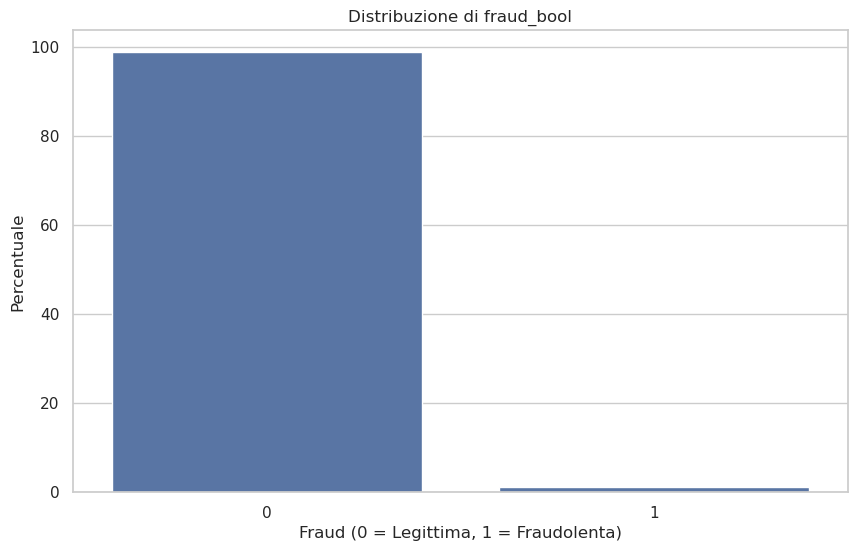

In [10]:
# Distribuzione del target fraud_bool
fraud_counts = df['fraud_bool'].value_counts(normalize=True) * 100
print(fraud_counts)
sns.barplot(x=fraud_counts.index, y=fraud_counts.values)
plt.title("Distribuzione di fraud_bool")
plt.xlabel("Fraud (0 = Legittima, 1 = Fraudolenta)")
plt.ylabel("Percentuale")
plt.show()

In [11]:
# Calcolo delle correlazioni
correlation_with_target = df[numeric_columns].corr()['fraud_bool'].sort_values(ascending=False)
correlation_summary = pd.DataFrame({
    'Variable': correlation_with_target.index,
    'Correlation_with_fraud_bool': correlation_with_target.values
}).reset_index(drop=True)
correlation_summary

,Variable,Correlation_with_fraud_bool
0,fraud_bool,1.000000
1,credit_risk_score,0.070588
2,proposed_credit_limit,0.068907
3,customer_age,0.062959
4,income,0.045079
5,device_distinct_emails_8w,0.036536
6,current_address_months_count,0.033459
7,email_is_free,0.027758
8,foreign_request,0.016885
9,month,0.013250


In [12]:
# Preparazione dei dati per il modello Random Forest
X = df[numeric_columns].drop(columns=['fraud_bool'])
y = df['fraud_bool']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
# Addestramento e valutazione del modello Random Forest
model = RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=100)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]
print("Classification Report:\n", classification_report(y_test, y_pred))
print("AUC-ROC Score:", roc_auc_score(y_test, y_proba))

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99    296691
           1       0.57      0.00      0.00      3309

    accuracy                           0.99    300000
   macro avg       0.78      0.50      0.50    300000
weighted avg       0.98      0.99      0.98    300000

AUC-ROC Score: 0.7842308204575547


In [14]:
# Creazione di nuove feature
df['velocity_ratio'] = df['velocity_6h'] / df['velocity_4w']
df['velocity_ratio'] = df['velocity_ratio'].replace([np.inf, -np.inf], np.nan)
df['velocity_ratio'] = df['velocity_ratio'].fillna(0)
print(df['velocity_ratio'].describe())

count    1000000.000000
mean           0.296654
std          567.342061
min      -347818.871073
25%           -0.489432
50%            0.423561
75%            1.357035
max       221494.058663
Name: velocity_ratio, dtype: float64


In [15]:
# Scalatura della nuova feature
scaler = RobustScaler()
df['velocity_ratio_scaled'] = scaler.fit_transform(df[['velocity_ratio']])
print(df['velocity_ratio_scaled'].describe())

count    1.000000e+06
mean    -6.872976e-02
std      3.072582e+02
min     -1.883702e+05
25%     -4.944537e-01
50%     -1.503174e-17
75%      5.055463e-01
max      1.199554e+05
Name: velocity_ratio_scaled, dtype: float64


In [16]:
# Creare la nuova feature 'Risk Score Normalizzato'
df['risk_normalized'] = df['credit_risk_score'] / df['proposed_credit_limit']

# Gestire divisioni per zero o valori mancanti
df['risk_normalized'] = df['risk_normalized'].replace([np.inf, -np.inf], np.nan).fillna(0)

# Controllare la nuova distribuzione della feature normalizzata
print(df['risk_normalized'].describe())

count    1000000.000000
mean           0.383552
std            0.249705
min           -0.850000
25%            0.186000
50%            0.346000
75%            0.540000
max            1.840000
Name: risk_normalized, dtype: float64


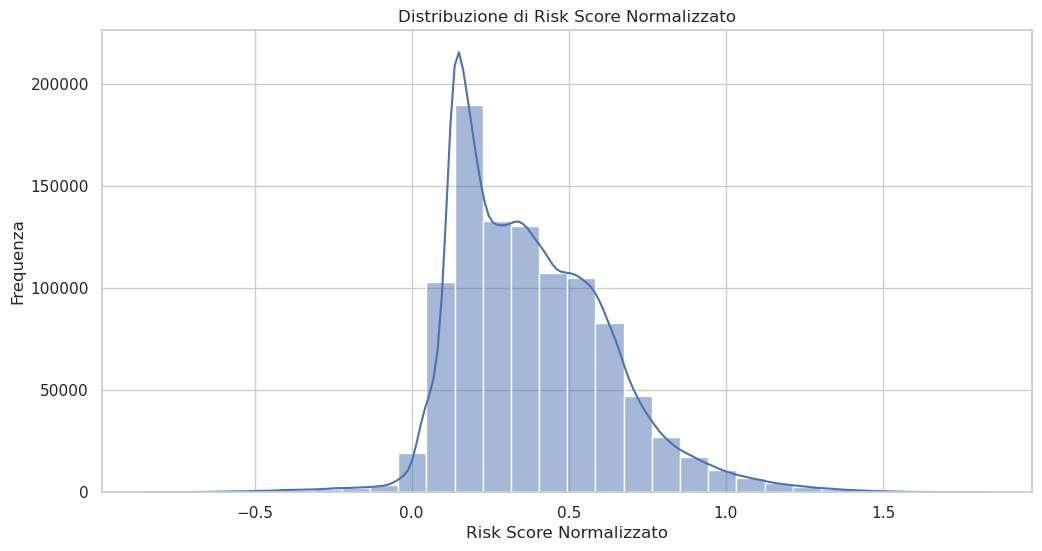

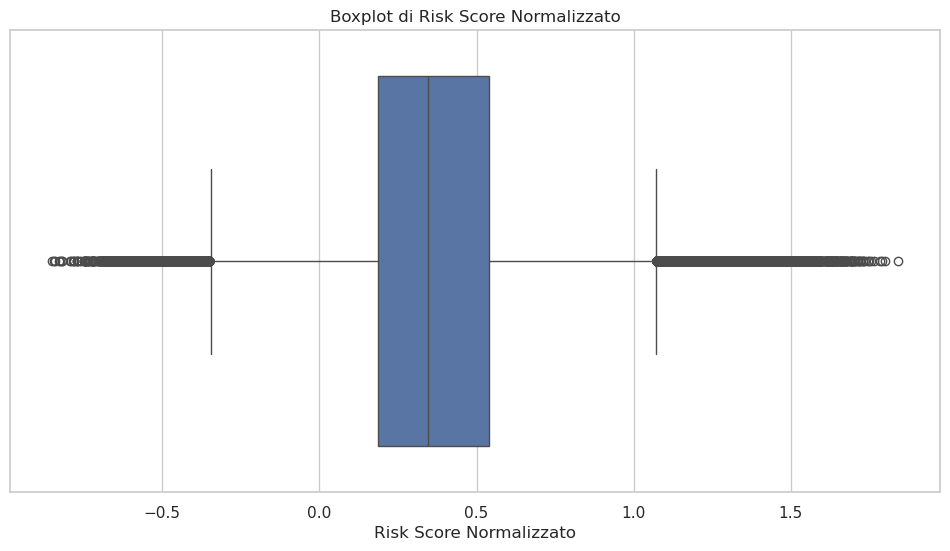

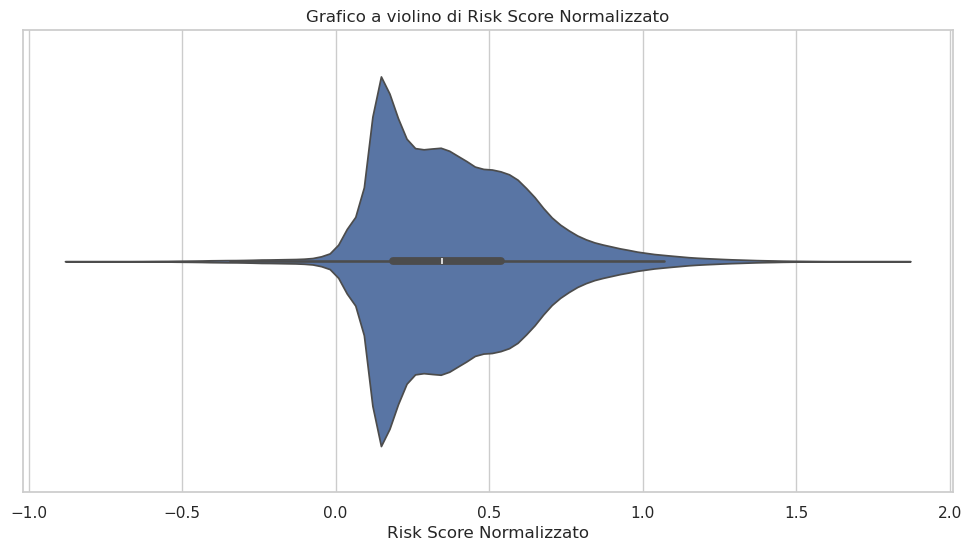

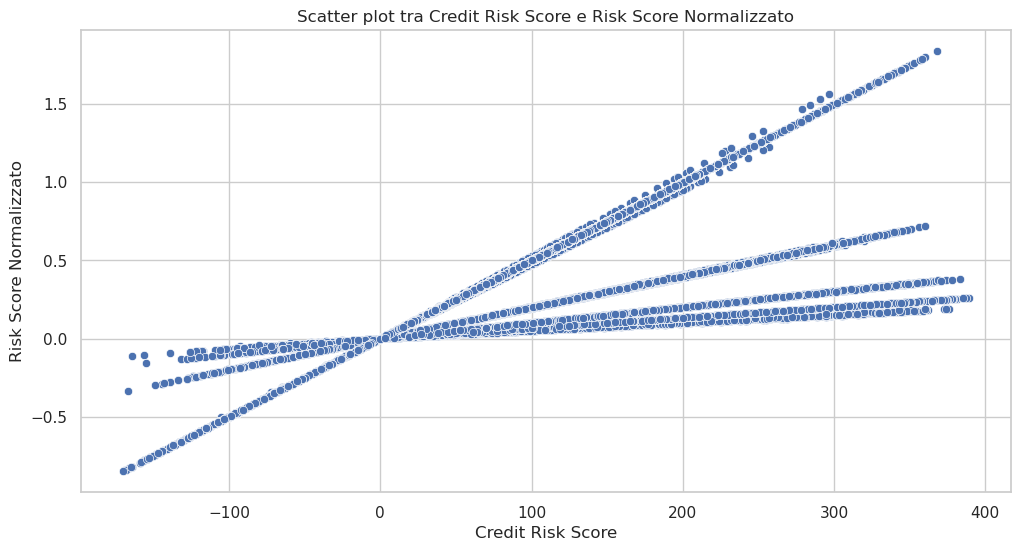

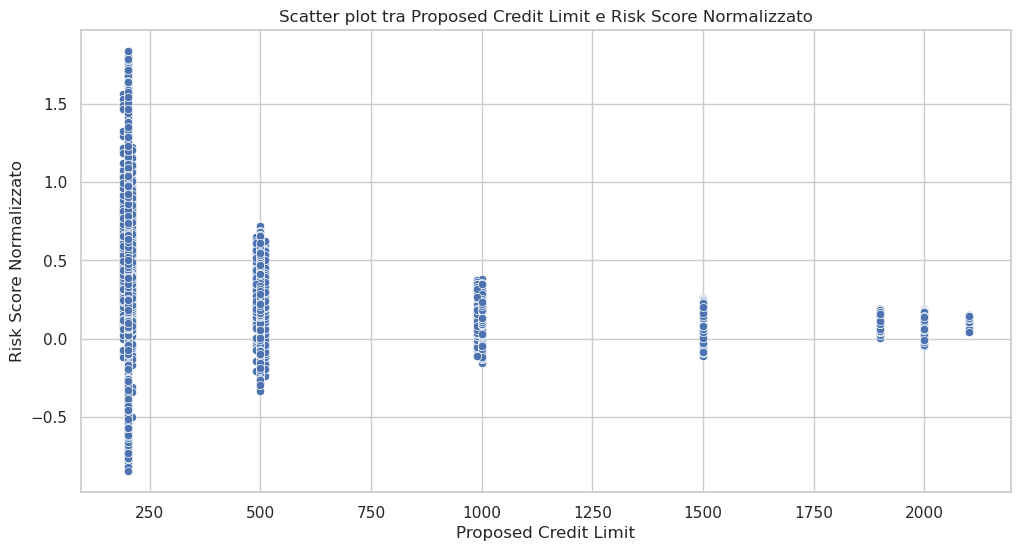

In [17]:

# Impostazioni di visualizzazione
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Istogramma della feature 'Risk Score Normalizzato'
plt.figure(figsize=(12, 6))
sns.histplot(df['risk_normalized'], bins=30, kde=True)
plt.title('Distribuzione di Risk Score Normalizzato')
plt.xlabel('Risk Score Normalizzato')
plt.ylabel('Frequenza')
plt.show()

# Boxplot della feature 'Risk Score Normalizzato'
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['risk_normalized'])
plt.title('Boxplot di Risk Score Normalizzato')
plt.xlabel('Risk Score Normalizzato')
plt.show()

# Grafico a violino della feature 'Risk Score Normalizzato'
plt.figure(figsize=(12, 6))
sns.violinplot(x=df['risk_normalized'])
plt.title('Grafico a violino di Risk Score Normalizzato')
plt.xlabel('Risk Score Normalizzato')
plt.show()

# Scatter plot tra 'Risk Score Normalizzato' e 'credit_risk_score'
plt.figure(figsize=(12, 6))
sns.scatterplot(x=df['credit_risk_score'], y=df['risk_normalized'])
plt.title('Scatter plot tra Credit Risk Score e Risk Score Normalizzato')
plt.xlabel('Credit Risk Score')
plt.ylabel('Risk Score Normalizzato')
plt.show()

# Scatter plot tra 'Risk Score Normalizzato' e 'proposed_credit_limit'
plt.figure(figsize=(12, 6))
sns.scatterplot(x=df['proposed_credit_limit'], y=df['risk_normalized'])
plt.title('Scatter plot tra Proposed Credit Limit e Risk Score Normalizzato')
plt.xlabel('Proposed Credit Limit')
plt.ylabel('Risk Score Normalizzato')
plt.show()

1. Istogramma di 'Risk Score Normalizzato'

Osservazioni:
La distribuzione è asimmetrica, con la maggior parte dei valori concentrati tra 0 e 0.5.
Ci sono alcune code, ma i valori estremi non sembrano dominare il dataset.
Conclusione: La distribuzione è coerente con l'interpretazione del rapporto rischio/credito. Questo è un buon punto di partenza per ulteriori analisi.


2. Boxplot di 'Risk Score Normalizzato'

Osservazioni:
I dati mostrano alcuni outlier sia sul lato negativo che positivo.
La maggior parte dei valori è all'interno del range interquartile (IQR), con una mediana vicina a 0.35.
Conclusione: Gli outlier potrebbero rappresentare casi interessanti da analizzare, specialmente se associati a frodi.


3. Grafico a violino di 'Risk Score Normalizzato'

Osservazioni:
La densità conferma la concentrazione di valori tra 0 e 0.5.
La simmetria nel range principale e la presenza di code evidenziano variazioni utili.
Conclusione: Questo grafico è meno informativo rispetto a istogramma e boxplot, ma conferma la distribuzione.


4. Scatter plot tra 'Credit Risk Score' e 'Risk Score Normalizzato'

Osservazioni:
Esiste una relazione lineare visibile tra le due variabili.
Le linee diagonali suggeriscono che il limite di credito (proposed_credit_limit) sta influenzando il risultato.
Conclusione: Questo scatter plot conferma che il Risk Score Normalizzato è fortemente legato al Credit Risk Score. Questa relazione potrebbe essere utile per identificare pattern o anomalie.


Valutazione complessiva

I grafici confermano che risk_normalized è una feature ben distribuita, con variazioni utili e potenziali outlier.
Il legame con credit_risk_score è chiaro, e la variabilità potrebbe essere un buon predittore di frode.

In [18]:
# Calcolare la correlazione tra 'risk_normalized' e 'fraud_bool'
correlation_with_fraud_bool = df[['risk_normalized', 'fraud_bool']].corr().iloc[0, 1]
print(f"Correlazione tra Risk Score Normalizzato e fraud_bool: {correlation_with_fraud_bool}")

Correlazione tra Risk Score Normalizzato e fraud_bool: -0.012296063254031576


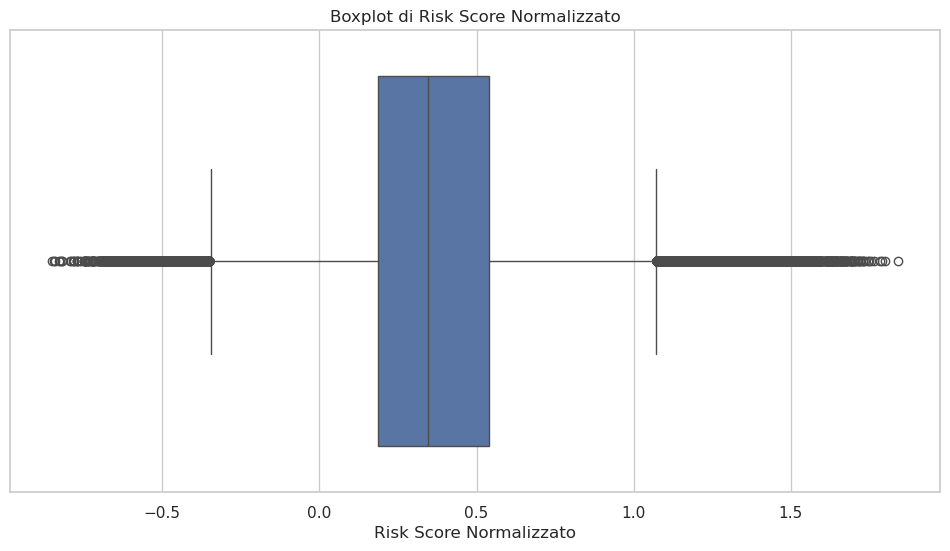

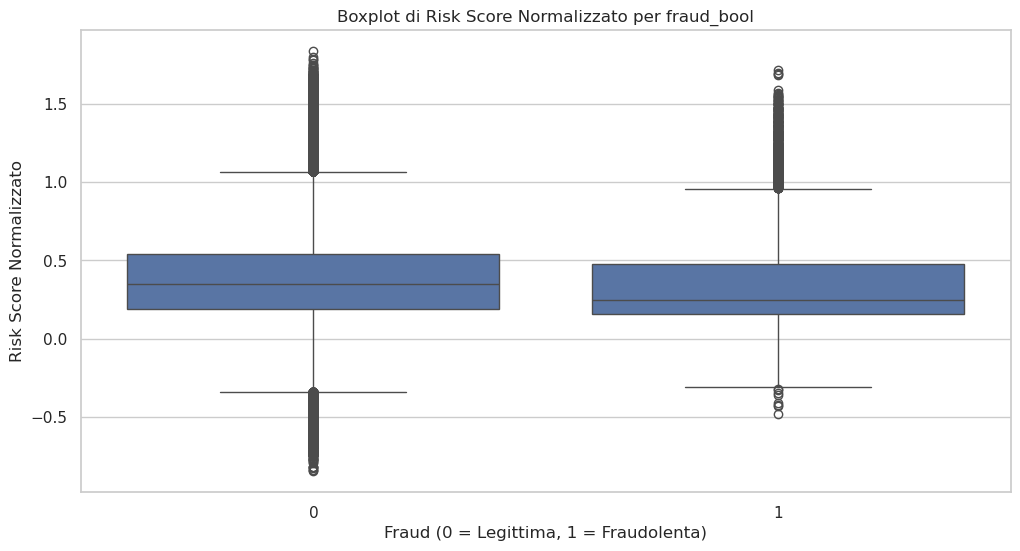

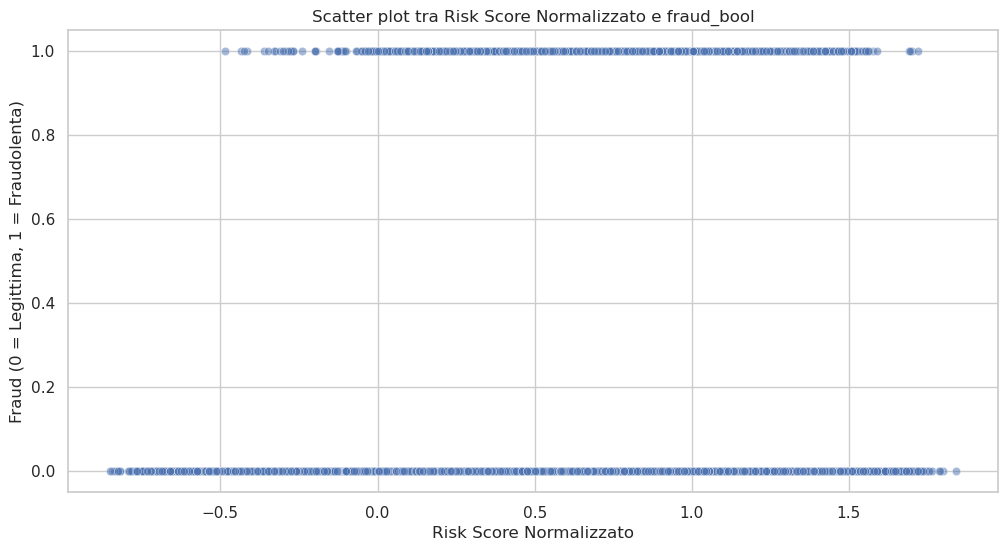

In [19]:
# Boxplot per visualizzare gli outlier in 'risk_normalized'
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['risk_normalized'])
plt.title('Boxplot di Risk Score Normalizzato')
plt.xlabel('Risk Score Normalizzato')
plt.show()

# Boxplot per visualizzare la relazione tra 'risk_normalized' e 'fraud_bool'
plt.figure(figsize=(12, 6))
sns.boxplot(x='fraud_bool', y='risk_normalized', data=df)
plt.title('Boxplot di Risk Score Normalizzato per fraud_bool')
plt.xlabel('Fraud (0 = Legittima, 1 = Fraudolenta)')
plt.ylabel('Risk Score Normalizzato')
plt.show()

# Scatter plot per visualizzare la relazione tra 'risk_normalized' e 'fraud_bool'
plt.figure(figsize=(12, 6))
sns.scatterplot(x='risk_normalized', y='fraud_bool', data=df, alpha=0.5)
plt.title('Scatter plot tra Risk Score Normalizzato e fraud_bool')
plt.xlabel('Risk Score Normalizzato')
plt.ylabel('Fraud (0 = Legittima, 1 = Fraudolenta)')
plt.show()

        weighted_risk  velocity_normalized  age_risk_weighted
count  1000000.000000       1000000.000000     1000000.000000
mean     88183.512586             0.000099        4554.051556
std     117359.703586             0.003948        3221.601818
min    -246000.000000            -0.009588      -10010.000000
25%      17400.000000            -0.002065        2250.000000
50%      26800.000000            -0.000221        3820.000000
75%     100470.000000             0.001683        6200.000000
max     752000.000000             0.015746       29250.000000


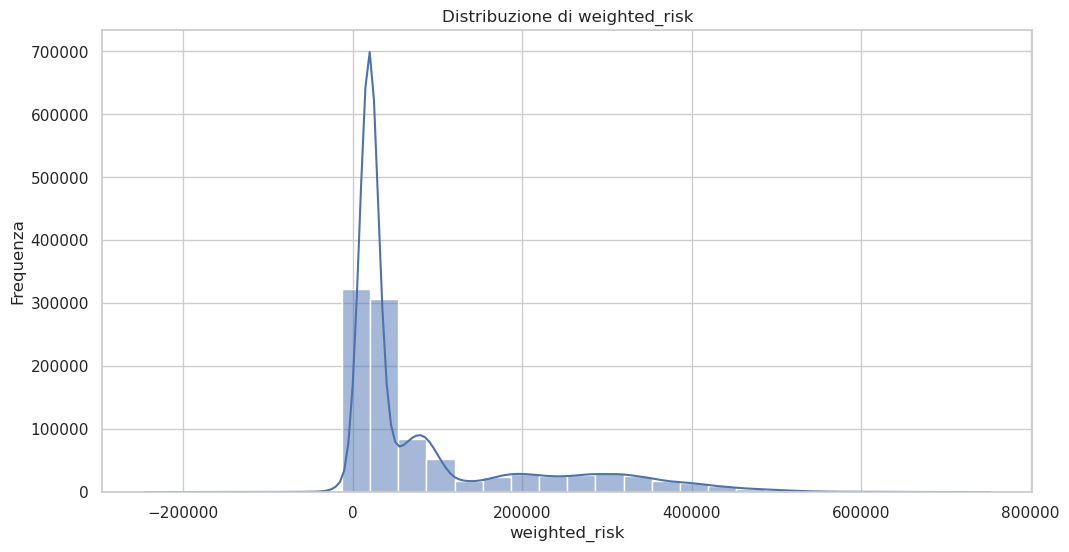

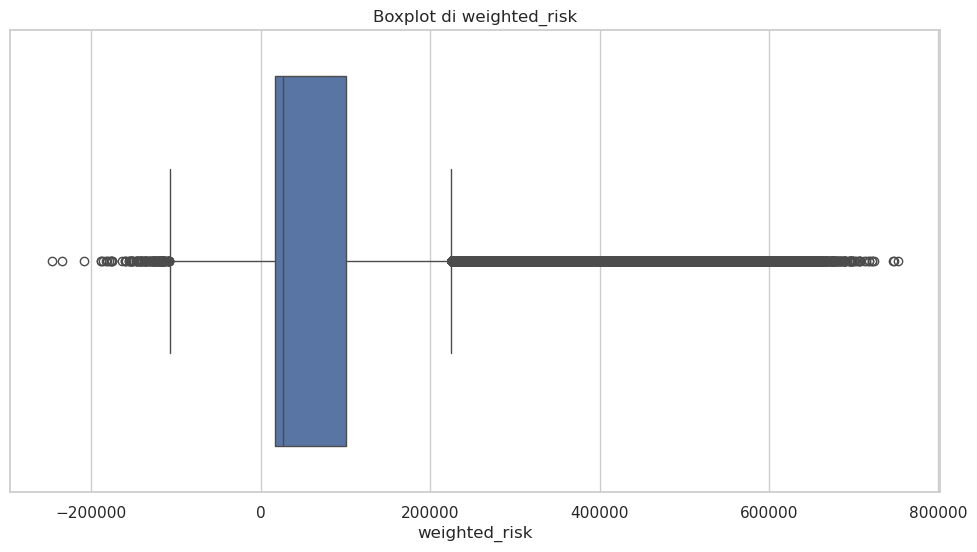

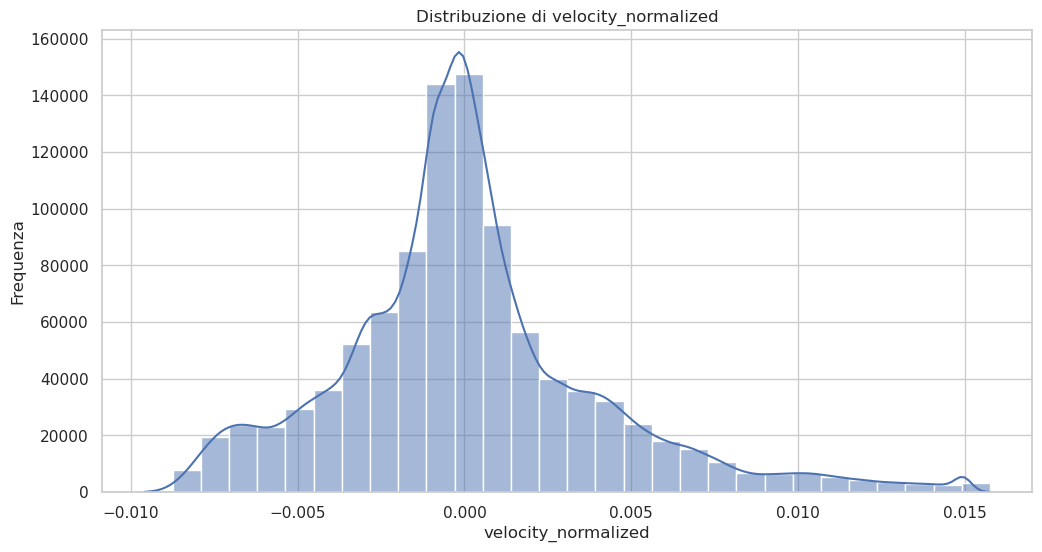

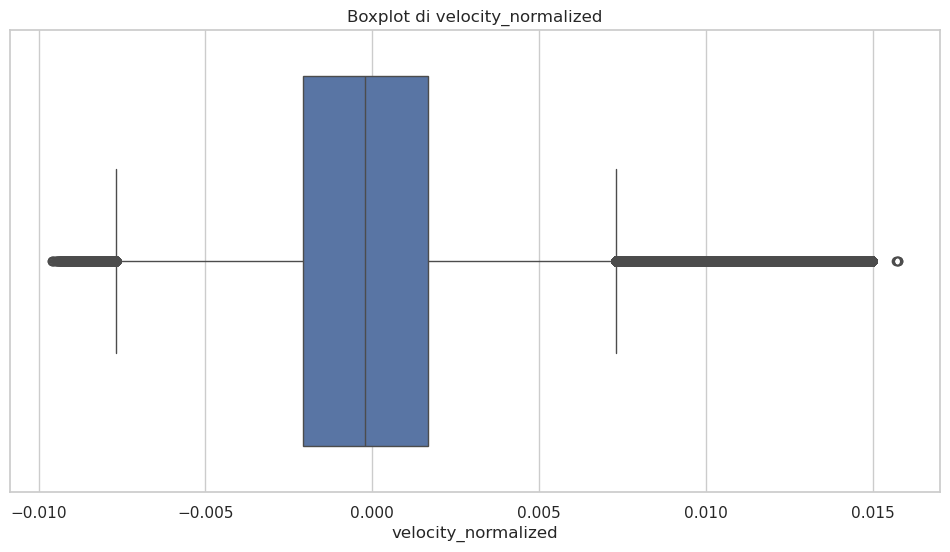

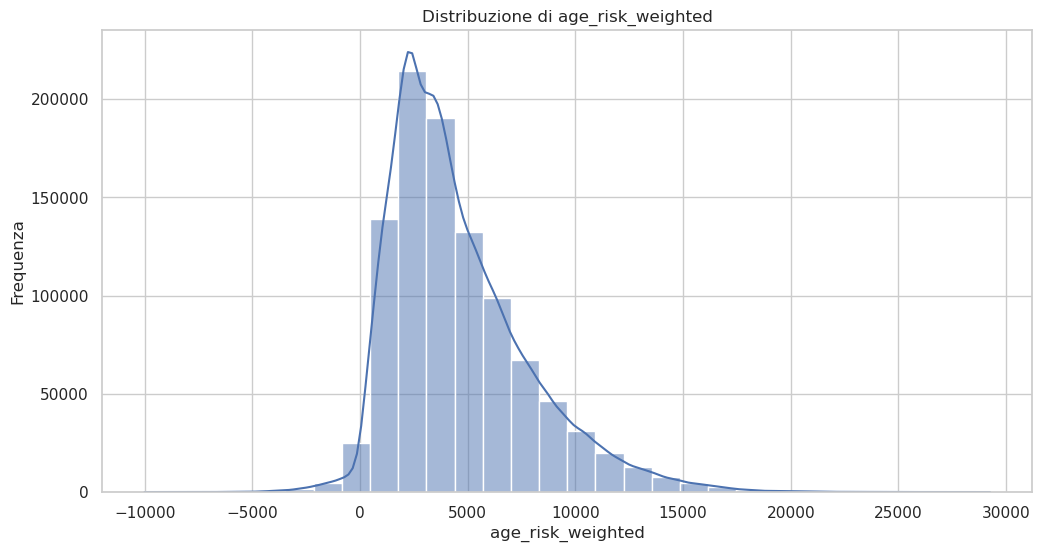

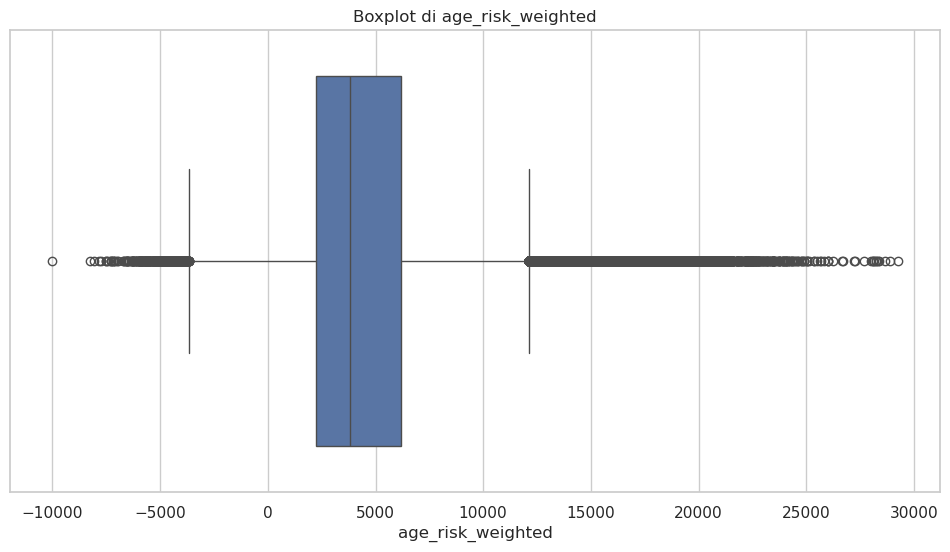

In [20]:
# Creazione di nuove feature
# 1. Rischio ponderato rispetto al limite di credito
df['weighted_risk'] = df['credit_risk_score'] * df['proposed_credit_limit']

# 2. Velocità di transazione normalizzata rispetto al limite di credito
df['velocity_normalized'] = df['velocity_6h'] / (df['proposed_credit_limit'] + 1)  # +1 per evitare divisioni per 0

# 3. Età ponderata rispetto al rischio
df['age_risk_weighted'] = df['customer_age'] * df['credit_risk_score']

# Statistiche descrittive per le nuove feature
print(df[['weighted_risk', 'velocity_normalized', 'age_risk_weighted']].describe())

# Visualizzazione con istogrammi e boxplot
for feature in ['weighted_risk', 'velocity_normalized', 'age_risk_weighted']:
    plt.figure(figsize=(12, 6))
    sns.histplot(df[feature], bins=30, kde=True)
    plt.title(f'Distribuzione di {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequenza')
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.boxplot(x=df[feature])
    plt.title(f'Boxplot di {feature}')
    plt.xlabel(feature)
    plt.show()

In [21]:
# Calcolo della correlazione con il target fraud_bool per le nuove feature
new_features = ['weighted_risk', 'velocity_normalized', 'age_risk_weighted']
correlations = {}

for feature in new_features:
    correlations[feature] = df[[feature, 'fraud_bool']].corr().iloc[0, 1]

# Creare un DataFrame per visualizzare i risultati
correlation_results = pd.DataFrame(list(correlations.items()), columns=['Feature', 'Correlation_with_fraud_bool'])
print(correlation_results)

               Feature  Correlation_with_fraud_bool
0        weighted_risk                     0.083892
1  velocity_normalized                    -0.009260
2    age_risk_weighted                     0.094297


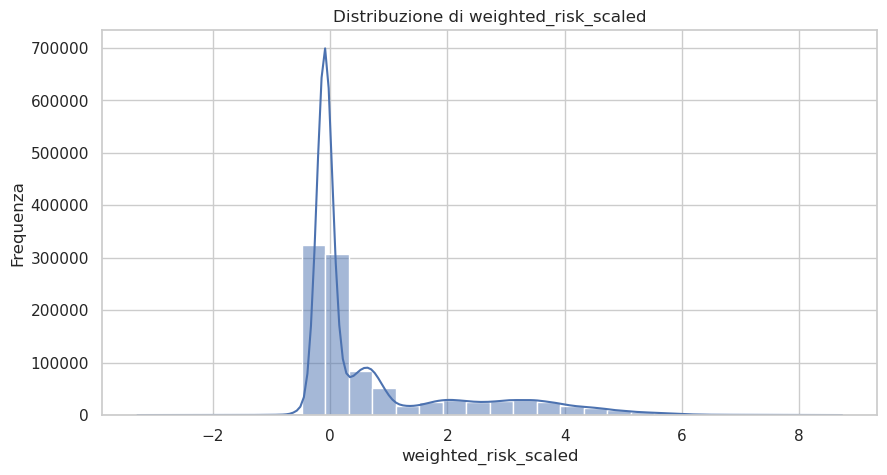

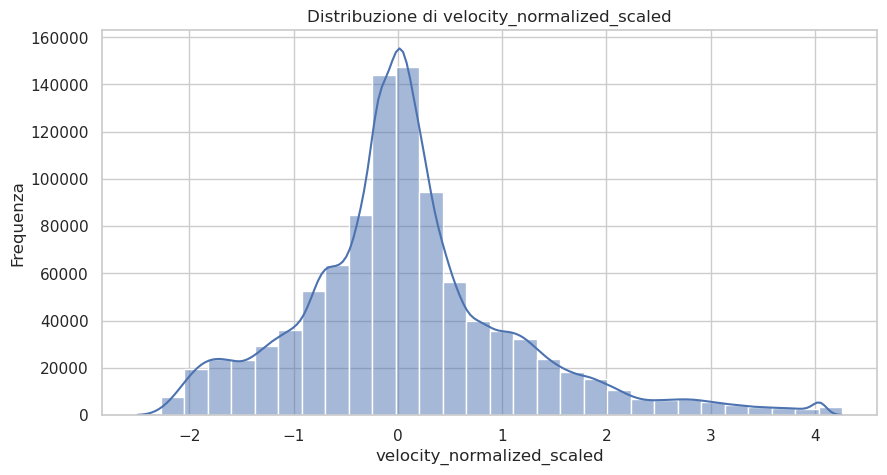

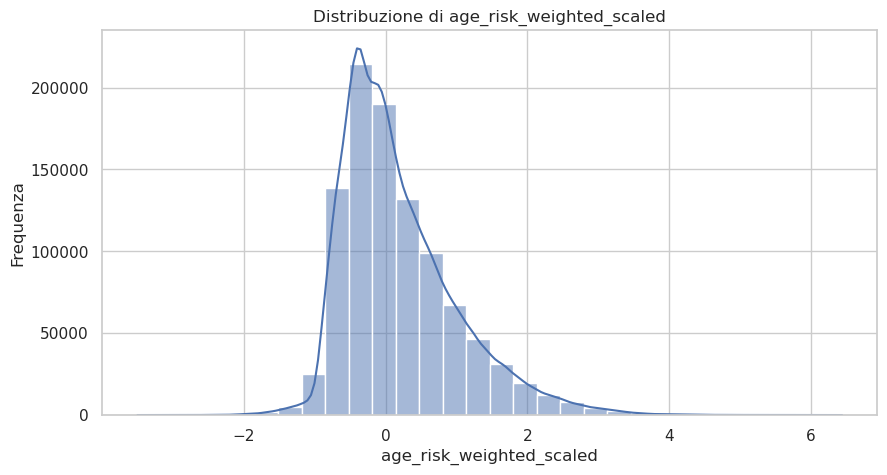

In [22]:
# Applicare RobustScaler per ridurre l'impatto degli outlier
scaler = RobustScaler()
for feature in new_features:
    df[f'{feature}_scaled'] = scaler.fit_transform(df[[feature]])

# Controllare la distribuzione delle feature trasformate
for feature in new_features:
    plt.figure(figsize=(10, 5))
    sns.histplot(df[f'{feature}_scaled'], bins=30, kde=True)
    plt.title(f'Distribuzione di {feature}_scaled')
    plt.xlabel(f'{feature}_scaled')
    plt.ylabel('Frequenza')
    plt.show()

In [23]:
# Aggiornare X con le nuove feature scalate
X = df[[col for col in numeric_columns if col != 'fraud_bool'] + [f'{feature}_scaled' for feature in new_features]]

# Dividere i dati in train e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Addestrare il modello Random Forest
model = RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=100)
model.fit(X_train, y_train)

# Valutazione del modello
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]
print("Classification Report:\n", classification_report(y_test, y_pred))
print("AUC-ROC Score:", roc_auc_score(y_test, y_proba))

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99    296691
           1       0.55      0.00      0.00      3309

    accuracy                           0.99    300000
   macro avg       0.77      0.50      0.50    300000
weighted avg       0.98      0.99      0.98    300000

AUC-ROC Score: 0.7784482989410062


In [24]:
# Dividere i dati in feature (X) e target (y)
X = df[numeric_columns].drop(columns=['fraud_bool'])
y = df['fraud_bool']

# Dividere il dataset in train e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Applicare SMOTE solo al set di addestramento
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Verificare la distribuzione dopo SMOTE
print("Distribuzione classi dopo SMOTE:")
print(y_train_smote.value_counts())

# Addestrare il modello Random Forest con i dati bilanciati
model = RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=100)
model.fit(X_train_smote, y_train_smote)

# Previsioni sul set di test
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Valutare il modello
print("Classification Report:\n", classification_report(y_test, y_pred))
print("AUC-ROC Score:", roc_auc_score(y_test, y_proba))

Distribuzione classi dopo SMOTE:
fraud_bool
0    692280
1    692280
Name: count, dtype: int64
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99    296691
           1       0.11      0.08      0.09      3309

    accuracy                           0.98    300000
   macro avg       0.55      0.54      0.54    300000
weighted avg       0.98      0.98      0.98    300000

AUC-ROC Score: 0.8067260991180591


# Bayesian Optimization per Random Forest

## Scopo:
Ottimizzare i parametri del modello Random Forest utilizzando la Bayesian Optimization.
Questo metodo bilancia esplorazione e sfruttamento, consentendo di trovare i migliori parametri senza testare tutte le combinazioni possibili.

## Parametri da ottimizzare:
- **n_estimators**: Numero di alberi nella foresta.
- **max_depth**: Profondità massima degli alberi.
- **min_samples_split**: Numero minimo di campioni richiesti per dividere un nodo interno.
- **min_samples_leaf**: Numero minimo di campioni in una foglia.

## Perché usare la Bayesian Optimization?
1. Efficienza: Minimizza il numero di iterazioni necessarie per trovare parametri ottimali.
2. Complessità: Adatto a modelli complessi e dataset grandi.
3. Risultati migliori: Bilancia esplorazione di nuovi parametri e sfruttamento di quelli già promettenti.

## Libreria utilizzata:
- **`bayes_opt`**: Una libreria Python per la Bayesian Optimization.


In [26]:
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

# Funzione obiettivo per la Bayesian Optimization con parallelizzazione
def rf_cv(n_estimators, max_depth, min_samples_split, min_samples_leaf):
    # Convertire i parametri in interi
    n_estimators = int(n_estimators)
    max_depth = int(max_depth)
    min_samples_split = int(min_samples_split)
    min_samples_leaf = int(min_samples_leaf)

    # Definire il modello Random Forest
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        class_weight='balanced',
        random_state=42
    )

    # Definire StratifiedKFold per mantenere la distribuzione del target nei fold
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    # Calcolare la validazione incrociata utilizzando AUC-ROC come metrica
    # Utilizziamo n_jobs=-1 per abilitare la parallelizzazione
    scores = cross_val_score(model, X_train_smote, y_train_smote, cv=cv, scoring='roc_auc', n_jobs=-1)
    return scores.mean()

# Definizione dello spazio dei parametri
param_bounds = {
    'n_estimators': (50, 200),
    'max_depth': (5, 50),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 10)
}

# Configurazione e avvio della Bayesian Optimization
optimizer = BayesianOptimization(
    f=rf_cv,
    pbounds=param_bounds,
    random_state=42,
    verbose=2
)

# Avvio dell'ottimizzazione
optimizer.maximize(init_points=8, n_iter=30)

# Recupero dei migliori parametri
best_params = optimizer.max['params']
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['max_depth'] = int(best_params['max_depth'])
best_params['min_samples_split'] = int(best_params['min_samples_split'])
best_params['min_samples_leaf'] = int(best_params['min_samples_leaf'])
print("Migliori parametri trovati:", best_params)


|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.993     | 21.85     | 9.556     | 7.856     | 139.8     |
| 2         | 0.9718    | 12.02     | 2.404     | 2.465     | 179.9     |
| 3         | 0.9975    | 32.05     | 7.373     | 2.165     | 195.5     |
| 4         | 0.9989    | 42.46     | 2.911     | 3.455     | 77.51     |
| 5         | 0.9897    | 18.69     | 5.723     | 5.456     | 93.68     |
| 6         | 0.9986    | 32.53     | 2.255     | 4.337     | 105.0     |
| 7         | 0.996     | 25.52     | 8.067     | 3.597     | 127.1     |
| 8         | 0.9985    | 31.66     | 1.418     | 6.86      | 75.58     |
| 9         | 0.9976    | 49.68     | 8.684     | 9.629     | 99.15     |
| 10        | 0.9988    | 41.85     | 2.754     | 4.339     | 76.01     |
| 11        | 0.9977    | 49.97     | 8.823     | 2.927     | 199.9     |
| 12        | 0.9899    | 18.64     | 

Test modello con parametri ottimizati

In [27]:
# Addestrare il modello finale con i parametri ottimizzati
final_model = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    class_weight='balanced',
    random_state=42
)

# Addestramento sul set di training ottimizzato (dati SMOTE)
final_model.fit(X_train_smote, y_train_smote)

# Previsioni sul set di test
y_pred = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)[:, 1]

# Valutazione del modello
print("Classification Report:\n", classification_report(y_test, y_pred))
print("AUC-ROC Score:", roc_auc_score(y_test, y_proba))

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99    296691
           1       0.11      0.09      0.10      3309

    accuracy                           0.98    300000
   macro avg       0.55      0.54      0.54    300000
weighted avg       0.98      0.98      0.98    300000

AUC-ROC Score: 0.8117126134159957
